In [1]:
%matplotlib notebook

from IPython.display import Image

from sdss import SDSS
import mikkel_tools.utility as mt_util
import plot as sds_plt

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pyshtools
import pickle

comment = "VirES VRE obs"
nb_name = "nb_seqsim_core_sh30_vires"

In [2]:
shn = 30
C_e_const = 2.0

core = SDSS(comment, N_SH = shn, sim_type = "core_ens", sat_height = 350)

core.grid_glq(nmax = shn, r_at = core.r_cmb)

grid_in = np.array([core.grid_phi, 90-core.grid_theta]).T
core.make_grid(core.r_cmb, grid_in, calc_sph_d = True)

core.generate_map(target_var_factor = 1)

core.condtab(normsize=10000, quantiles = 100, 
             rangn_lim = 3.5, rangn_N = 101, rangv_lim = 2.0, rangv_N = 101)

core.semivar(model_lags = 20, model = "exponential", max_dist = 20000, lag_length = 100,
             zero_nugget = True, hit_target_var = False)


____semi-variogram setup___

Number of data used: 3575881
Max data distance: 10919.075 km
Lag length chosen: 100.0 km
Number of lags: 109
Number of modelling lags: 20

Semi-variogram model determined, starting LUT computation



<IPython.core.display.Javascript object>


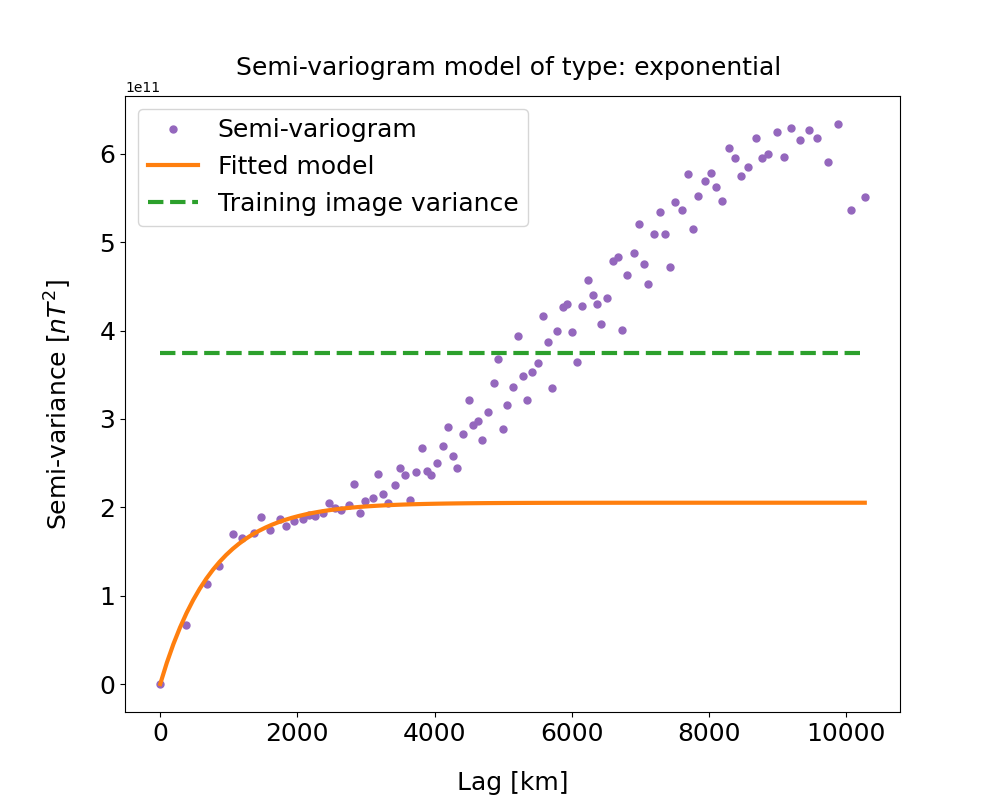

In [3]:
#%% PLOT SEMI-VARIOGRAM
plt.figure(figsize=(10,8)) 
plt.plot(core.lags,core.pics,'o', markersize=5,color = 'C4',label='Semi-variogram')
plt.plot(core.lags_sv_curve,core.sv_curve,color='C1', linewidth = 3,label='Fitted model')
plt.plot(core.lags_sv_curve,np.ones(core.lags_sv_curve.shape)*core.target_var,linewidth = 3,
         color="C2", linestyle="dashed", label="Training image variance")
plt.ylabel('Semi-variance $[%s^2]$' % "nT",fontsize=18,labelpad=18)
plt.xlabel('Lag [km]',fontsize=18,labelpad=18)
plt.title("Semi-variogram model of type: %s " % core.model_names[core.model],fontsize=18,y=1.02)
plt.legend(loc='best',fontsize=18)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.show()

# Swarm observations through VirES VRE

In [4]:
import datetime as dt
from viresclient import SwarmRequest

request = SwarmRequest()

In [5]:
collect = "SW_OPER_MAGA_LR_1B"

In [6]:
#request.available_measurements("MAG")

In [7]:
use_meas = ["B_NEC"]

In [8]:
#request.available_auxiliaries()

In [9]:
use_aux = ["SunZenithAngle", "Kp", "QDLat", "Dst"]

In [10]:
#request.available_models(details=False)

In [11]:
use_models = ["M_use = 'LCS-1' + 'CHAOS-MMA-Primary' + 'CHAOS-MMA-Secondary' + 'MIO_SHA_2C'"]

In [51]:
request.set_collection(collect)

request.set_products(measurements=use_meas,
                     models = use_models,
                     auxiliaries=use_aux,
                     residuals=False,
                     sampling_step="PT5M")

data = request.get_between(start_time=dt.datetime(2019,2,1),
                           end_time=dt.datetime(2019,5,1))

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:49, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (2.993MB)


In [52]:
ds = data.as_xarray()
print(ds)

<xarray.Dataset>
Dimensions:         (NEC: 3, Timestamp: 25632)
Coordinates:
  * Timestamp       (Timestamp) datetime64[ns] 2019-02-01 ... 2019-04-30T23:55:00
  * NEC             (NEC) <U1 'N' 'E' 'C'
Data variables:
    Spacecraft      (Timestamp) object 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    B_NEC           (Timestamp, NEC) float64 1.928e+04 2.107e+03 ... -1.184e+04
    B_NEC_M_use     (Timestamp, NEC) float64 -30.9 -11.0 10.04 ... 3.928 0.4434
    SunZenithAngle  (Timestamp) float64 61.95 81.27 100.6 ... 121.4 120.9 116.6
    Kp              (Timestamp) float64 5.3 2.3 2.3 2.3 2.3 ... 1.3 1.3 1.3 1.3
    Longitude       (Timestamp) float64 -174.5 -172.9 -157.8 ... 64.06 63.76
    Dst             (Timestamp) float64 -12.5 -12.08 -11.67 ... 8.5 9.0 9.5
    QDLat           (Timestamp) float64 40.6 60.65 81.25 ... -31.37 -10.53
    Radius          (Timestamp) float64 6.809e+06 6.806e+06 ... 6.817e+06
    Latitude        (Timestamp) float64 44.68 63.94 82.88 ... -22.19 -2.94
Attribu

<IPython.core.display.Javascript object>


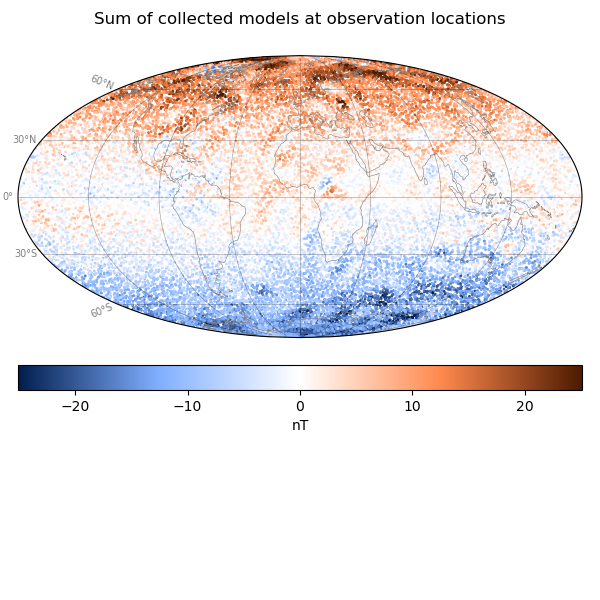

In [53]:
mt_util.plot_global(lat = ds.Latitude.values, lon = ds.Longitude.values, data=ds["B_NEC_M_use"].values[:,2], 
                cbar_h = 0.075, cbar_mm_factor = 2/3, unit_transform_n_to_m = False,
                cbar_text = "nT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Sum of collected models at observation locations', point_size=1,
                savefig = False, save_dpi = 100, save_string ="vre_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

In [57]:
SZA_angle = 110
Kp_max = 2
dDst_max = 2
QDlat_max = 90

idx_sort = np.logical_and.reduce((np.abs(ds.SunZenithAngle.values)>SZA_angle, ds.Kp.values<=Kp_max, abs(ds.QDLat.values)<QDlat_max, abs(np.diff(ds.Dst.values,prepend=0))/(5/60) <=dDst_max))

In [58]:
obs_sat = SDSS(comment, N_SH = shn)

obs_sat.data = -ds["B_NEC"].values[:,2][idx_sort] #+ ds["B_NEC_M_use"].values[:,2][idx_sort] 

obs_sat.r_grid = ds.Radius[idx_sort].values/10**3
obs_sat.lon = ds.Longitude[idx_sort].values
obs_sat.lat = ds.Latitude[idx_sort].values
obs_sat.grid_N = len(obs_sat.data)

In [59]:
print(obs_sat)


______current attributes______

a:                6371.2
r_sat:            6721.2
r_cmb:            3480.0
rad:              0.017453292519943295
mu0:              1.2566370614359173e-06
comment:          VirES VRE obs
class_abs_path:   /home/mikotz/spherical_direct_sequential_simulation
N_SH:             30
N_SH_secondary:   None
sim_type:         core
data:             (2899,), Max/Min: 53209.64 / -49158.62
r_grid:           (2899,), Max/Min: 6822.88 / 6803.76
lon:              (2899,), Max/Min: 179.96 / -179.81
lat:              (2899,), Max/Min: 84.10 / -79.49
grid_N:           2899



<IPython.core.display.Javascript object>


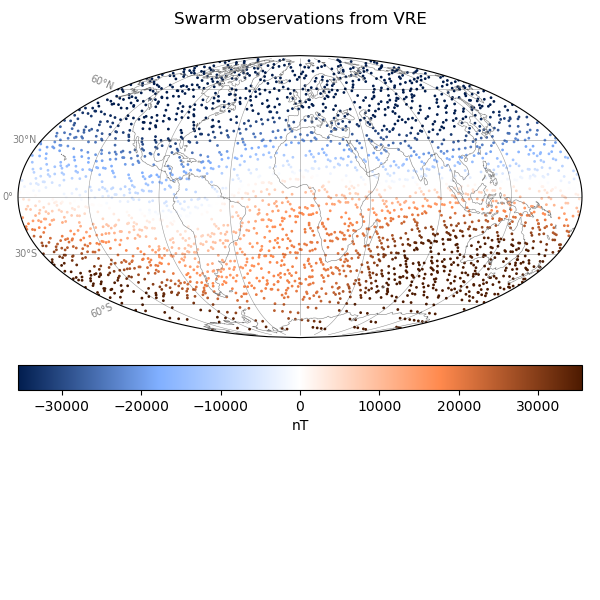

In [61]:
mt_util.plot_global(lat = obs_sat.lat, lon = obs_sat.lon, data=obs_sat.data, 
                cbar_h = 0.075, cbar_mm_factor = 2/3, unit_transform_n_to_m = False,
                cbar_text = "nT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Swarm observations from VRE', point_size=1,
                savefig = False, save_dpi = 100, save_string ="vre_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

# Kernel

In [62]:
core.grid_glq(nmax = shn, r_at = core.r_cmb)
core.integrating_kernel(obs_sat, C_e_const = C_e_const)

# Equivalent LSQ

In [63]:
core.covmod_lsq_equiv(obs_sat.data, core.C_mm_all, core.G, core.r_cmb)

<IPython.core.display.Javascript object>


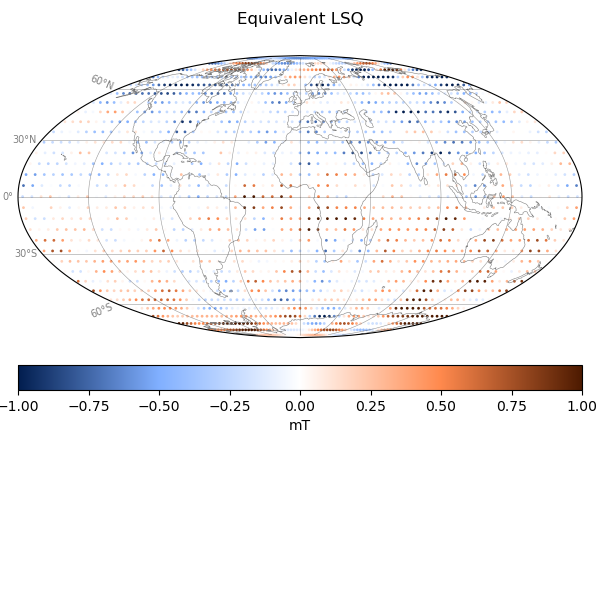

In [64]:
mt_util.plot_global(lat = core.lat, lon = core.lon, data=np.ravel(core.m_equiv_lsq), limits_data = [-1,1],
                cbar_h = 0.075, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Equivalent LSQ', point_size=1,
                savefig = False, save_dpi = 100, save_string ="vre_obs_lsq",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

In [65]:
core.grid_glq(nmax = 256, r_at = core.r_cmb)
core.ensemble_B(core.g_lsq_equiv, nmax = shn, r_at = core.r_cmb, grid_type = "glq")
lsq_eqa = core.B_ensemble[:,0].copy()

In [66]:
core.grid_glq(nmax = shn, r_at = core.r_cmb)

obs_sat.data = -ds["B_NEC"].values[:,2][idx_sort] + ds["B_NEC_M_use"].values[:,2][idx_sort] 

core.covmod_lsq_equiv(obs_sat.data, core.C_mm_all, core.G, core.r_cmb)
core.grid_glq(nmax = 256, r_at = core.r_cmb)
core.ensemble_B(core.g_lsq_equiv, nmax = shn, r_at = core.r_cmb, grid_type = "glq")
lsq_eqa_m_use = core.B_ensemble[:,0].copy()

<IPython.core.display.Javascript object>


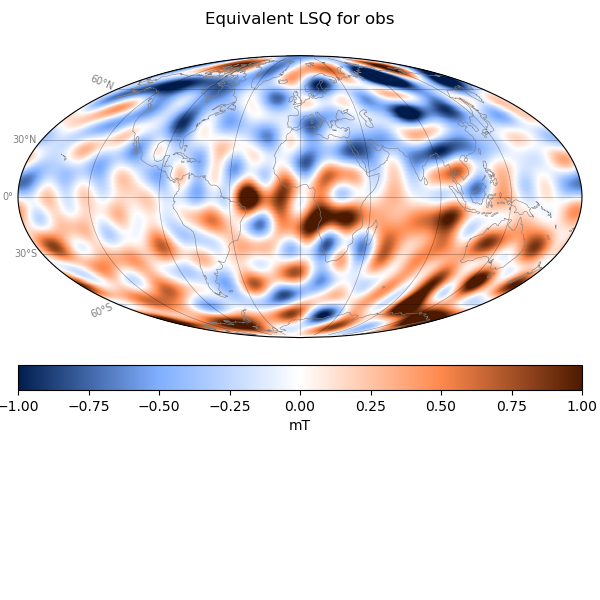

<IPython.core.display.Javascript object>


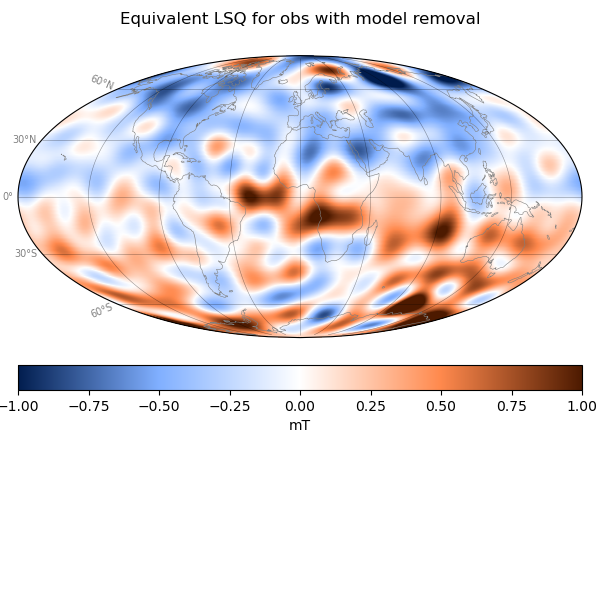

In [67]:
mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=lsq_eqa, limits_data = [-1,1],
                cbar_h = 0.075, cbar_mm_factor = 3/3, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Equivalent LSQ for obs', point_size=1,
                savefig = False, save_dpi = 100, save_string ="vre_obs_lsq",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=lsq_eqa_m_use, limits_data = [-1,1],
                cbar_h = 0.075, cbar_mm_factor = 3/3, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Equivalent LSQ for obs with model removal', point_size=1,
                savefig = False, save_dpi = 100, save_string ="vre_obs_lsq",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

 |OOOOOOOOOO| 100.0%   realization nr. 0. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 12.049 minutes 
Total elapsed time: 12.049 minutes 
Variance: 222378420489.351
Mean: -1027.182
Max: 1784876.155
Min: -1695937.622
Run nr.: 1

 |OOOOOOOOOO| 100.0%   realization nr. 1. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 11.192 minutes 
Total elapsed time: 23.241 minutes 
Variance: 215052700387.033
Mean: 3004.780
Max: 2111394.134
Min: -2103111.298
Run nr.: 2

 |OOOOOOOOOO| 100.0%   realization nr. 2. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 10.917 minutes 
Total elapsed time: 34.158 minutes 
Variance: 223460435817.703
Mean: -1528.500
Max: 1965342.980
Min: -1692821.560
Run nr.: 3

 |OOOOOOOOOO| 100.0%   realization nr. 3. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 10.899 minutes 
Total elapsed time: 45.056 minutes 
Variance: 219910226229.542
Mean: 1296.931
Max: 2356331.603
Min: -2018755.973
Run nr.: 4

 |OOOOOOOOOO| 100.0%   realiza

<IPython.core.display.Javascript object>


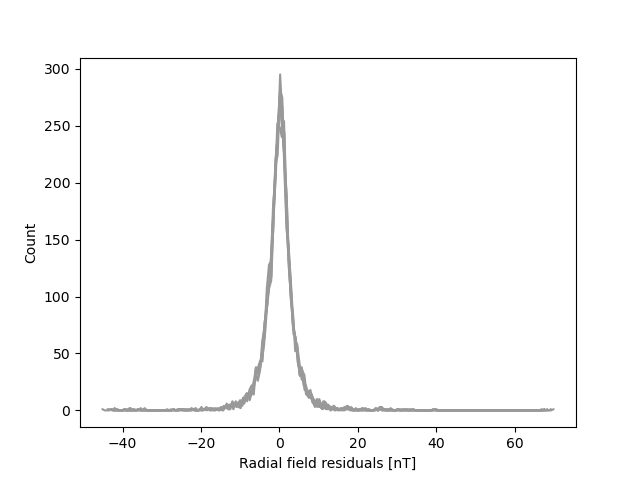

In [68]:
core.grid_glq(nmax = shn, r_at = core.r_cmb)

N_sim = 6

core.run_sim(N_sim, core.grid_N, core.C_mm_all, core.C_dd, core.C_dm_all, core.G,
        obs_sat.data, core.data, scale_m_i = True, unit_d = False, collect_all = False,
        sense_running_error = True, save_string = nb_name, sim_stochastic = False, solve_cho = True)

In [69]:
core.realization_to_sh_coeff(core.r_cmb, set_nmax = shn)

# Evaluation

<IPython.core.display.Javascript object>


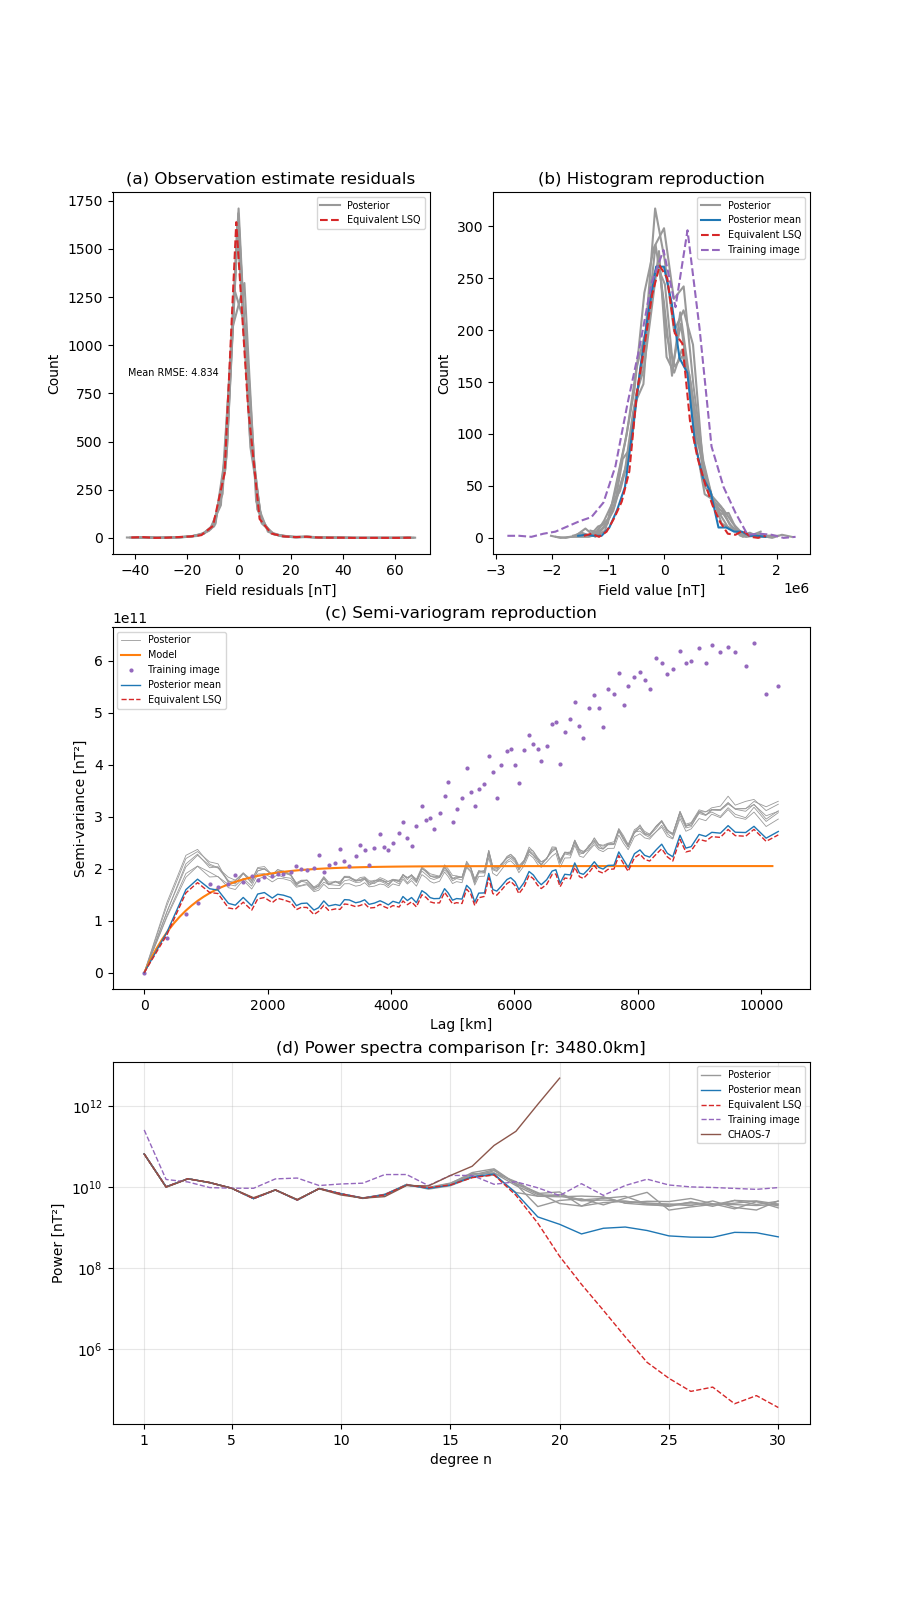

In [70]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

core.grid_glq(nmax = shn, r_at = core.r_cmb)
mt_util.plot_sdssim_reproduce(core, core.m_DSS_res, m_equiv_lsq = core.m_equiv_lsq, truth_obj = None,
                              lags_use = 1000, spec_r_at = core.r_cmb, spec_show_differences = False,
                              model_dict = {"CHAOS-7"}, figsize=(9,16), spec_chaos_time = [2016,1,1],
                              hist_bins = 25, res_bins = 25,
                              savefig = False, save_string = "vre_obs", save_dpi = 300)

In [71]:
core.grid_glq(nmax = 256, r_at = core.r_cmb)

set_nmax = shn

core.ensemble_B(core.g_spec, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_eqa = core.B_ensemble[:,0,:].copy()

#core.g_spec_mean = np.mean(core.g_spec,axis=1)
core.ensemble_B(core.g_spec_mean, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_mean_eqa = core.B_ensemble[:,0].copy()

core.ensemble_B(core.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
prior_eqa = core.B_ensemble[:,0].copy()

core.ensemble_B(core.g_lsq_equiv, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
lsq_eqa = core.B_ensemble[:,0].copy()

<IPython.core.display.Javascript object>


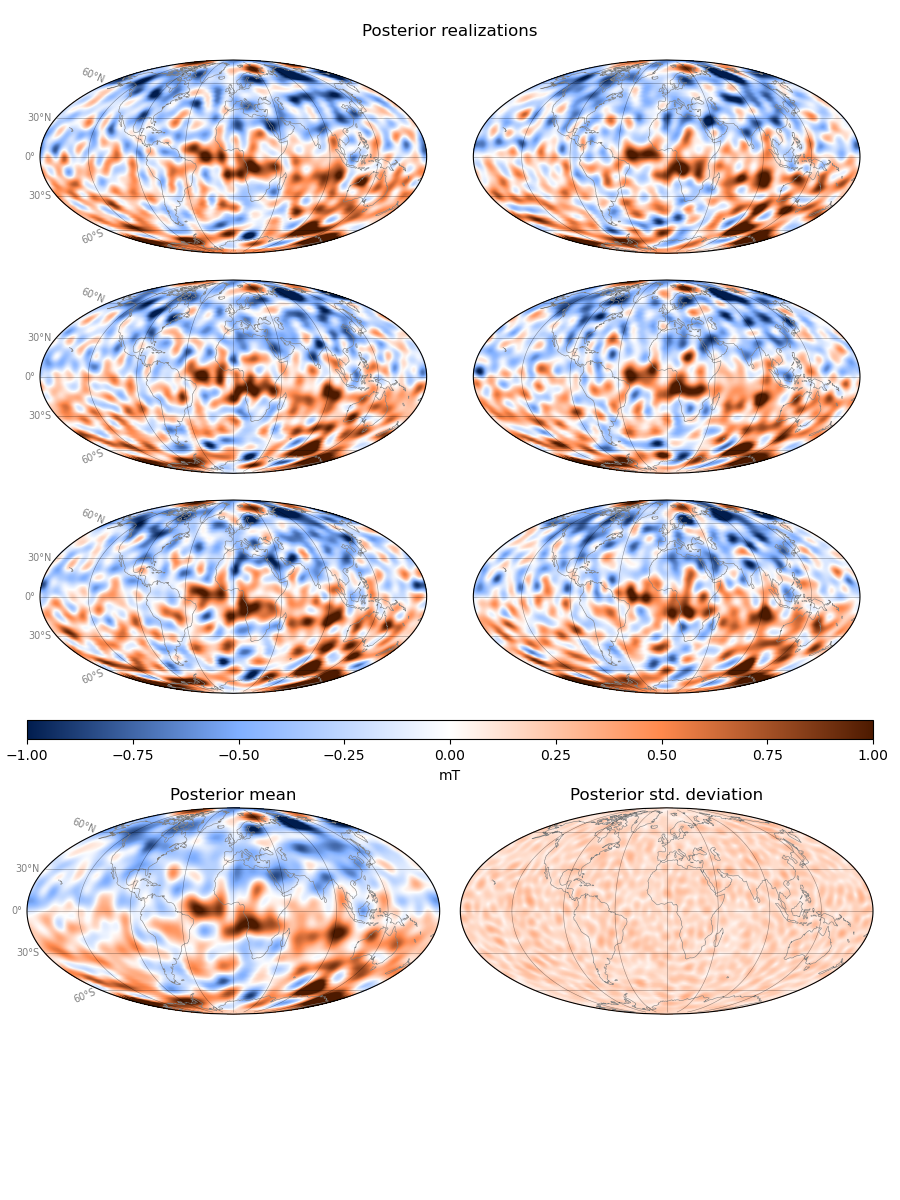

In [74]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

mt_util.plot_ensemble_map_tiles(core.grid_phi, 90-core.grid_theta, zs_eqa,
                        field_mean = zs_mean_eqa,
                        tile_size_row = 4, tile_size_column = 2, 
                        figsize=(9,12), limit_for_SF = 10**6, point_size = 10,
                        coast_width = 0.4, coast_color = "grey", unit_transform_n_to_m = True,
                        cbar_h = 0.1, cbar_text = "mT", cbar_text_color = "black", cbar_limit = [-1,1],
                        left=0.03, bottom=0.12, right=0.97, top=0.95, wspace = 0.05, hspace=0.15, 
                        savefig = False, save_string = "vre_obs", 
                        projection = ccrs.Mollweide(), use_gridlines = True, 
                        gridlines_width = 0.4, gridlines_alpha = 0.4, save_dpi = 100)
